# Guía No. 4 - Simulaciones de Monte Carlo
----
by: Diego Dorado

## Modelo de Ising 2D
----

Considere el modelo de Ising en la red cuadrada de $N = L \times L$ sitios (parámetro de red unitario) con interacciones entre primeros vecinos:

$$
H
=
-J\sum_{\langle i,j \rangle}S_iS_j
-
B\sum_iS_i
$$

Usando condiciones de contorno periódicas y tomando la energía en unidades de $k_B$ (esto es, tomando $k_B=1$) implemente un programa para simular las propiedades termodinámicas del modelo usando el algoritmo de Metropolis.

### Algoritmo de Metropolis

El algoritmo de Metropolis permite simular sistemas en equilibrio termodinámico mediante una cadena de configuraciones que respeta la distribución de Boltzmann.  
En el caso del modelo de Ising en 2D, una configuración corresponde al estado de todos los espines en la red.

1. **Inicialización de la configuración**: Elegir una configuración inicial arbitraria $ \alpha $.

    *Ising:* $ \alpha = (S_1, S_2, \dots, s_N)$, con $s_i = \pm 1$, representa todos los espines iniciales de la red.  

2. **Selección de un espín candidato**: Elegir una nueva configuración $\alpha'$ por algún método y se calcula $\Delta E = E(\alpha') - E(\alpha)$

    *Ising:* Elegir un sitio $ i $ de la red y proponer un cambio (flip) de espín: $ S_i \to -S_i $
     
   - El sitio puede elegirse:
       - **Secuencialmente:** recorrer todos los sitios en orden.
       - **Aleatoriamente:** seleccionar con probabilidad uniforme $ 1/N $.

3. **Criterio de aceptación**
   - Si $ \Delta E \leq 0 $, aceptar siempre el cambio.  
   - Si $ \Delta E > 0 $, aceptar el cambio con probabilidad: $p = e^{-\beta \Delta E}$ y se rechaza con probabilidad $1-p=1- e^{-\beta \Delta E}$.

    Para implementar esto en el código:  
     - Generar un número aleatorio $ r \in [0,1) $.  
     - Aceptar el cambio si $ r < p $.  

4. **Actualización de la configuración**
   - Si el cambio se acepta, la nueva configuración $ \alpha' $ pasa a ser el estado actual.  
   - Si se rechaza, se mantiene la configuración $ \alpha $.

5. **Repetición del proceso**
   - Repetir los pasos 2–5 muchas veces para generar una cadena de configuraciones.
   - Cada barrido de $ N $ intentos de flip se considera un **Monte Carlo step (MCS)**.

## Código
-----

### Paquetes
---

In [50]:
using Statistics
using Random
using Plots
using LaTeXStrings

### Funciones

In [120]:
# Vecinos cercanos
function cn(spins, x, y, i; J=1.0, B=0.0)
    Lx, Ly = size(spins)
    h = 0.0
    # Interacción con vecinos periódicos
    h -= J * spins[x, y] * (spins[mod1(x+i,Lx), y] + spins[x, mod1(y+i,Ly)])

    # Campo magnético externo
    h -= B * spins[x, y]
    return h
end

# Hamiltoniano de Ising 2d
function h_ising_2d(spins, J=1.0, B=0.0)
    Lx, Ly = size(spins)
    H = 0.0

    for x in 1:Lx
        for y in 1:Ly
            H += cn(spins, x, y, 1, J=J, B=B)
        end
    end

    return H
end

# Algoritmo de Metropolis

function metropolis!(spins, t, L; J=1.0, B=0.0)    
    # Nueva configuración de spins
    x = rand(1:L)
    y = rand(1:L)
    ΔE = -2 * (cn(spins, x, y, 1, J=J, B=B) + cn(spins, x, y, -1, J=J, B=B))  # cambio de energía

    # Criterio de aceptación
    if ΔE <= 0 || rand() < exp(-ΔE/t)
        spins[x,y] *= -1  # aceptamos el flip
        return ΔE
    else
        return 0.0  # no aceptamos el flip
    end
end

function run_MC(T, L; J=1.0, B=0.0, N_therm=5000, N_samples=10000)
    m_exp = zeros(length(T))  # magnetización esperada

    for (i,t) in enumerate(T)
        # Estado inicial
        spins = rand([-1, 1], L, L)
        m = zeros(N_samples)
        H = zeros(N_samples)
    
        # Termalización
        for _ in 1:N_therm
            metropolis!(spins, t, L; J=J, B=B)
        end
        E_total = h_ising_2d(spins, J, B)  # energía inicial

        # Muestreo
        for j in 1:N_samples
            ΔE = metropolis!(spins, t, L; J=J, B=B)
            E_total += ΔE             # actualizamos energía

            # Cálculo de observables
            m[j] = mean(spins)
            H[j] = E_total            # guardamos la energía actual
        end
        m_exp[i] = mean(abs.(m))
    end
    return m_exp
end

run_MC (generic function with 1 method)

### Main
---

In [128]:
# Configuración inicial
J = 1.0            # Constante de acoplamiento
B = 0.0            # Campo magnético externo
T = 1.0:0.05:4.0   # Rango de temperaturas

1.0:0.05:4.0

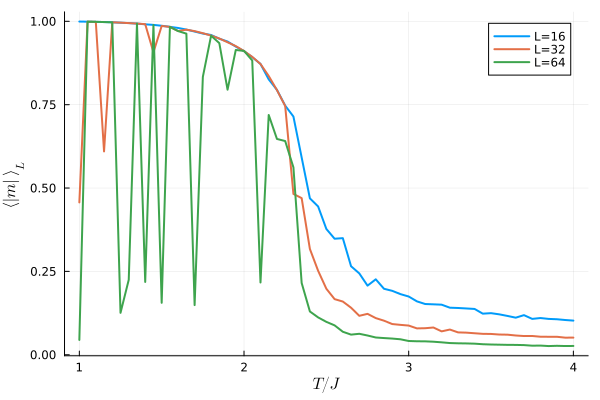

In [129]:
p=plot(xlabel=L"$T/J$", ylabel=L"$\langle |m| \rangle_L$")
for l in [16, 32, 64]
    m_exp = run_MC(T, l; J=J, B=B, N_therm=500*l^2, N_samples=5000*l^2)
    plot!(
        T ./ J,
        m_exp, 
        label="L=$l",
        lw=2
    )
end

display(p)